In [83]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [216]:
import pandas as pd 
import numpy as np
import yfinance as yf 
import datetime as dt 
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import cufflinks as cf
cf.go_offline()
import itertools 

In [272]:
class arga:
    
    def __init__(self, ticker, start_date, end_date, interval):
        self.ticker = ticker
        self.start = start_date
        self.end = end_date
        self.interval = interval
        self.data_gathering()
        self.fit_arima()
        self.fit_garch()
        self.generate_signals()
        self.calculate_strategy_returns()
        self.plot_cumulative_returns()
        self.analysis()

    def data_gathering(self):
        self.data = yf.download(self.ticker, self.start, self.end, self.interval).dropna()
        return 

    def fit_arima(self, max_p=3, max_d=1, max_q=3):
        pdq = itertools.product(range(max_p + 1), range(max_d + 1), range(max_q + 1))

        # Filtering out models that don't converge using list comprehension
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            models = [(order, ARIMA(self.data['Adj Close'], order=order).fit()) for order in pdq]

        # Finding the model with the lowest AIC
        best_order, best_model = min(models, key=lambda x: x[1].aic, default=(None, None))

        if best_model is not None:
            print(f"Best ARIMA Model: Order={best_order}, AIC={best_model.aic}")
            self.arima_order = best_order
            self.arima_model = best_model
            self.data['arima_residuals'] = best_model.resid
            self.data['arima_prediction'] = best_model.predict(start=self.data.index[0], end=self.data.index[-1])
        else:
            print("No suitable ARIMA model found.")
            
    def fit_garch(self, max_p=2, max_q=2):
        pq_combinations = itertools.product(range(1, max_p + 1), range(max_q + 1))

        # Filter out models that don't converge using list comprehension
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            models = [(params, arch_model(self.data['arima_residuals'], vol='Garch', p=params[0], q=params[1]).fit(disp='off')) for params in pq_combinations]

        # Find the model with the lowest AIC
        best_params, best_model = min(models, key=lambda x: x[1].aic, default=(None, None))

        if best_model is not None:
            print(f"Best GARCH Model: Params={best_params}, AIC={best_model.aic}")
            self.garch_params = best_params
            self.garch_model = best_model
            self.data['garch_volatility'] = best_model.conditional_volatility
        else:
            print("No suitable GARCH model found.")

    def generate_signals(self):
        # Pre-calculate quantile values to avoid recalculating them for each row
        low_vol_threshold = self.data['garch_volatility'].quantile(0.05)
        high_vol_threshold = self.data['garch_volatility'].quantile(0.95)

        # Generate buy and sell signals
        self.data['buy_signal'] = np.where(
            (self.data['arima_residuals'] > 0) & (self.data['garch_volatility'] < low_vol_threshold),
            1,
            0
        )

        self.data['sell_signal'] = np.where(
            (self.data['arima_residuals'] < 0) & (self.data['garch_volatility'] > high_vol_threshold),
            -1,
            0
        )

        
    def calculate_strategy_returns(self, target_pct=0.05, stop_loss_pct=0.02):
        self.data['entry_price'] = 0
        self.data['exit_price'] = 0
        self.data['trade_return'] = 0
        position = 0  # No position initially

        for index, row in self.data.iterrows():
            # Entry Logic
            if position == 0 and (row['buy_signal'] == 1 or row['sell_signal'] == -1):
                position = 1 if row['buy_signal'] == 1 else -1
                entry_price = row['Adj Close']
                self.data.at[index, 'entry_price'] = entry_price
                target_price = entry_price * (1 + target_pct)
                stop_loss_price = entry_price * (1 - stop_loss_pct)

            # Exit Logic
            elif position != 0:
                current_price = row['Adj Close']
                exit_signal = (position == 1 and (current_price >= target_price or current_price <= stop_loss_price)) \
                          or (position == -1 and (current_price <= target_price or current_price >= stop_loss_price))

                if exit_signal:
                    self.data.at[index, 'exit_price'] = current_price
                    trade_return = (current_price - entry_price) / entry_price if position == 1 else (entry_price - current_price) / entry_price
                    self.data.at[index, 'trade_return'] = trade_return
                    position = 0  # Reset position

        # Calculate cumulative returns
        self.data['cumulative_returns'] = (1 + self.data['trade_return']).cumprod()
       
        print(len(self.data['buy_signal']))
        print(len(self.data['sell_signal']))
        print(self.data)

    def plot_cumulative_returns(self):
        # Calculate buy-and-hold returns
        #self.data['buy_and_hold_returns'] = (self.data['Adj Close'] / self.data['Adj Close'].iloc[0]).cumprod()

        plt.figure(figsize=(10, 6))
        plt.plot(self.data.index, self.data['cumulative_returns'], label='Strategy Returns', color='blue')
        #plt.plot(self.data.index, self.data['buy_and_hold_returns'], label='Buy and Hold Returns', color='orange')
        plt.title(f'Cumulative Returns for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.show()

        
    def analysis(self, risk_free_rate=0.02):
        # Calculate daily returns
        daily_returns = self.data['Adj Close'].pct_change()

        # Annualized mean return and standard deviation
        annualized_mean_return = daily_returns.mean() * 252
        annualized_std_dev = daily_returns.std() * np.sqrt(252)

        # Sharpe ratio
        sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_std_dev

        # Drawdown
        previous_peaks = self.data['cumulative_returns'].cummax()
        drawdown = self.data['cumulative_returns'] - previous_peaks
        max_drawdown = drawdown.min()

        # Sortino ratio
        downside_returns = daily_returns[daily_returns < 0]
        downside_std_dev = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_mean_return - risk_free_rate) / downside_std_dev if downside_std_dev != 0 else float('inf')

        print("Sharpe Ratio:", sharpe_ratio)
        print("Max Drawdown:", max_drawdown)
        print("Sortino Ratio:", sortino_ratio)




In [273]:
end = dt.date.today()
start = end - pd.Timedelta(days= 252)
end
start

datetime.date(2023, 11, 17)

datetime.date(2023, 3, 10)

[*********************100%%**********************]  1 of 1 completed
Best ARIMA Model: Order=(2, 1, 2), AIC=1636.984992894101
Best GARCH Model: Params=(1, 1), AIC=1692.66681844696
169
169
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-03-10  2341.500000  2344.000000  2315.050049  2322.699951  2314.523926   
2023-03-13  2329.000000  2344.000000  2275.000000  2284.500000  2276.458496   
2023-03-14  2280.000000  2304.949951  2269.050049  2275.949951  2267.938477   
2023-03-15  2284.100098  2298.300049  2227.399902  2237.050049  2229.175537   
2023-03-16  2243.000000  2254.000000  2202.199951  2225.899902  2218.064697   
...                 ...          ...          ...          ...          ...   
2023-11-09  2335.850098  2335.899902  2304.199951  2310.550049  2310.550049   
2023-11-10  2305.550049  2316.350098  2298.050049  2314.899902  2314.899902   
2023-11-13  2322.89990

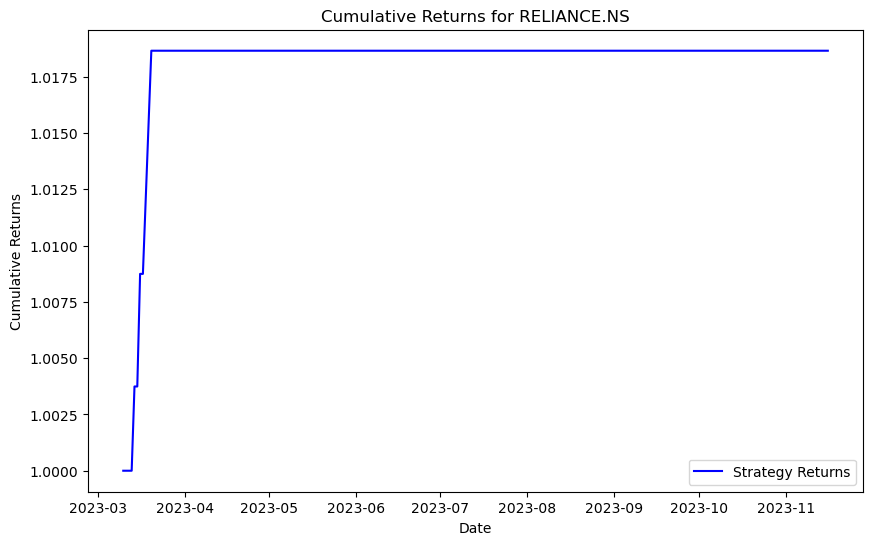

Sharpe Ratio: 0.14807852735881247
Max Drawdown: 0.0
Sortino Ratio: 0.1851266416049362


In [275]:
calm = arga("RELIANCE.NS", start, end, interval="1d")